In [1]:
import cv2
import yaml
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from copy import deepcopy

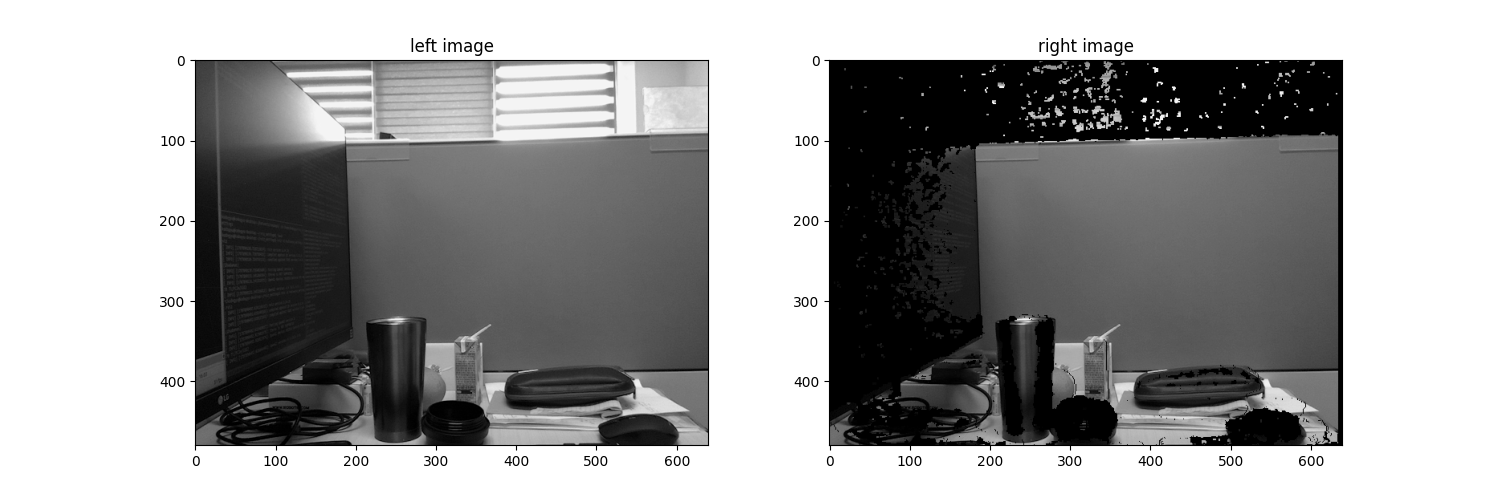

yaml file loaded.


In [2]:
# Image read
left_image = cv2.imread('../ipynb/color_frames/color_image484.png', cv2.IMREAD_GRAYSCALE)
left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
right_image = cv2.imread('../ipynb/right_frames/right_image484.png', cv2.IMREAD_GRAYSCALE)
right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)

# YAML file read
import yaml

yaml_filename = "/home/kodogyu/kimera_multi_ws/src/kimera_vio/params/L515_stereo/FrontendParams.yaml"
with open(yaml_filename, "r") as stream:
    stream.readline()  # %YAML:1.0 건너뛰기
    yaml_data = yaml.safe_load(stream)

# Confirm
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(left_image)
axs[0].set_title("left image")
axs[1].imshow(right_image)
axs[1].set_title("right image")
plt.show()

print("yaml file loaded.")

In [52]:
# Global variables
FX = 648.62802467
BASELINE = 0.008889568098128261

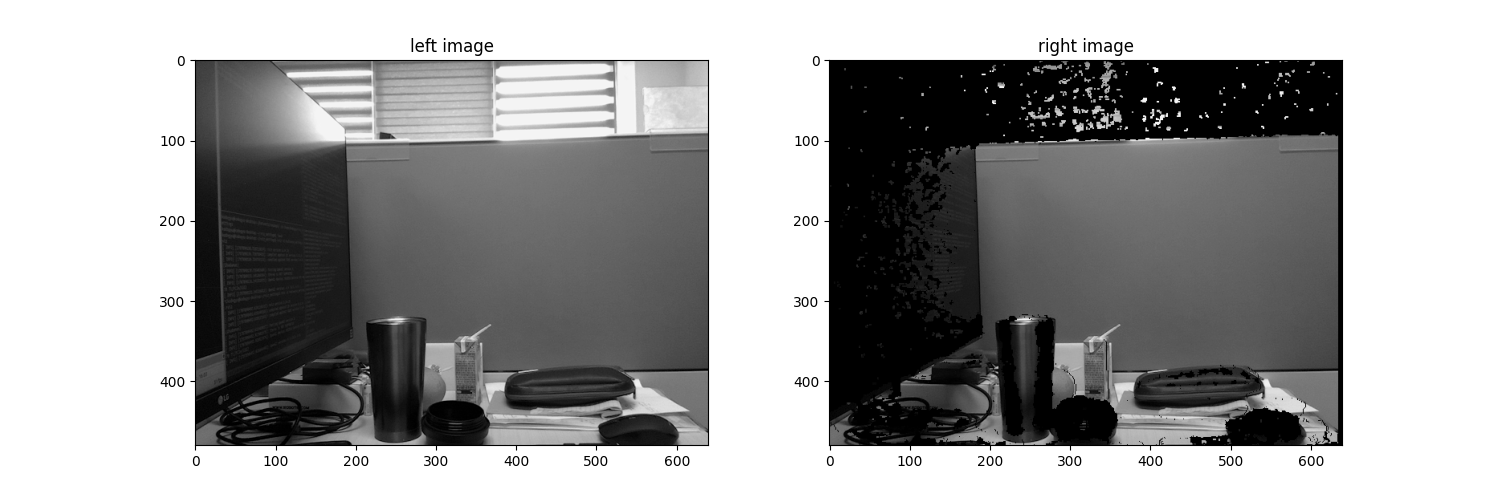

In [53]:
# Get keypoints
gftt_detector = cv2.GFTTDetector.create(yaml_data["max_nr_keypoints_before_anms"], 
                                        yaml_data["quality_level"],
                                        10,  # yaml_data["min_distance_btw_tracked_and_detected_features"],
                                        yaml_data["block_size"],
                                        yaml_data["use_harris_detector"],
                                        yaml_data["k"])

lkf_kps = gftt_detector.detect(left_image, None)
# Right image features are not needed
# rkf_kps = gftt_detector.detect(right_image, None)

left_key_frame_kp = cv2.drawKeypoints(left_image, lkf_kps, None)
# right_key_frame_kp = cv2.drawKeypoints(right_image, rkf_kps, None)

# fig, axs = plt.subplots(1, 2, figsize=(half_width, 5))
# fig.suptitle("GFTT detector")
# axs[0].imshow(left_key_frame_kp)
# axs[0].set_title("left image")
# axs[1].imshow(right_key_frame_kp)
# axs[1].set_title("right image")
plt.show()

In [54]:
def getTemplate(left_image, left_kp, templ_rows, templ_cols):
    temp_status = "KeypointStatus::VALID"
    temp_corner_y = int(left_kp.pt[1] - (templ_rows - 1) / 2)
    if (temp_corner_y < 0 or temp_corner_y + templ_rows >
                                left_image.shape[0] - 1):
        right_keypoint_status = "KeypointStatus::NO_RIGHT_RECT"
        print("template corner y out of bound")
        print(f"keypoint: {left_kp.pt}")
        print(f"template_corner_y: {temp_corner_y}")
        print(right_keypoint_status)

    offset_temp = 0
    temp_corner_x = int(left_kp.pt[0] - (templ_cols - 1) / 2)
    if (temp_corner_x < 0):
        offset_temp = temp_corner_x
        temp_corner_x = 0
    if (temp_corner_x + templ_cols >
        left_image.shape[1] - 1):
        offset_temp = (temp_corner_x + templ_cols) - (left_image.shape[1] - 1)
        temp_corner_x -= offset_temp

    templ = left_image[temp_corner_y:temp_corner_y+templ_rows,
                    temp_corner_x:temp_corner_x+templ_cols]

    left_templ = deepcopy(left_image)
    cv2.rectangle(left_templ,
                (temp_corner_x, temp_corner_y),
                (temp_corner_x+templ_cols, temp_corner_y+templ_rows),
                (255, 0, 0),
                2)
    cv2.circle(left_templ,
            tuple(map(int, left_kp.pt)),
            3,
            (255, 0, 0),
            2)

    return left_templ, templ, offset_temp, temp_status

template (row, col): 11 , 101


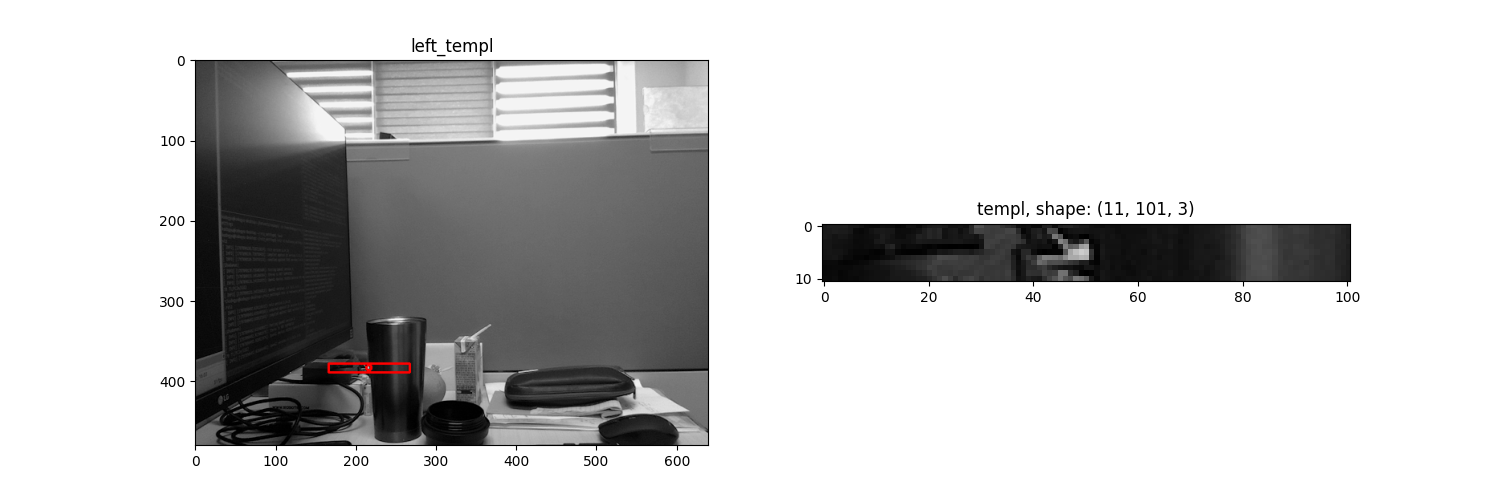

In [55]:
left_kp = lkf_kps[0]

# Make a template
templ_rows = yaml_data["templ_rows"]
templ_cols = yaml_data["templ_cols"]
print("template (row, col):", templ_rows, ",", templ_cols)

left_templ, templ, _, temp_status = getTemplate(left_image=left_image,
                                                left_kp=left_kp,
                                                templ_rows=templ_rows,
                                                templ_cols=templ_cols)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(left_templ)
axs[0].set_title("left_templ")
axs[1].imshow(templ)
axs[1].set_title(f"templ, shape: {templ.shape}")
plt.show()

In [56]:
def getStripe(right_image, left_kp, templ_rows, templ_cols, stripe_extra_rows):
    # fx = 648.62802467
    # baseline = 0.008889568098128261
    stripe_status = "KeypointStatus::VALID"
    
    stripe_rows = int(templ_rows + stripe_extra_rows)
    stripe_cols = int(FX * BASELINE / yaml_data["minPointDist"] + templ_cols + 4)

    if (stripe_cols % 2 != 1):
        stripe_cols += 1
    if (stripe_cols > right_image.shape[0]):
        stripe_cols = right_image.shape[0]

    stripe_corner_y = int(left_kp.pt[1] - (stripe_rows - 1) / 2)

    offset_stripe = 0
    stripe_corner_x = int(left_kp.pt[0] + (templ_cols - 1) / 2 - stripe_cols)

    if (stripe_corner_y < 0 or stripe_corner_y + stripe_rows > right_image.shape[0] - 1):
        stripe_status = "KeypointStatus::NO_RIGHT_RECT"
        print("stripe corner y out of bound")
        print(f"keypoint: {left_kp.pt}")
        print(f"stripe_corner_y: {stripe_corner_y}")
        print(stripe_status)

    if (stripe_corner_x + stripe_cols > right_image.shape[1] - 1):
        offset_stripe = (stripe_corner_x + stripe_cols) - (right_image.shape[1] - 1)
        stripe_corner_x -= offset_stripe

    if stripe_corner_x < 0:
        stripe_corner_x = 0

    stripe = right_image[stripe_corner_y:stripe_corner_y+stripe_rows,
                        stripe_corner_x:stripe_corner_x+stripe_cols]
    stripe_corner = (stripe_corner_x, stripe_corner_y)    

    right_stripe = deepcopy(right_image)
    cv2.rectangle(right_stripe, 
                (stripe_corner_x, stripe_corner_y),
                (stripe_corner_x+stripe_cols, stripe_corner_y+stripe_rows),
                (255, 0, 0),
                2)
    cv2.circle(right_stripe,
            tuple(map(int, left_kp.pt)),
            3,
            (255, 0, 0),
            2)

    return right_stripe, stripe, stripe_corner, stripe_status

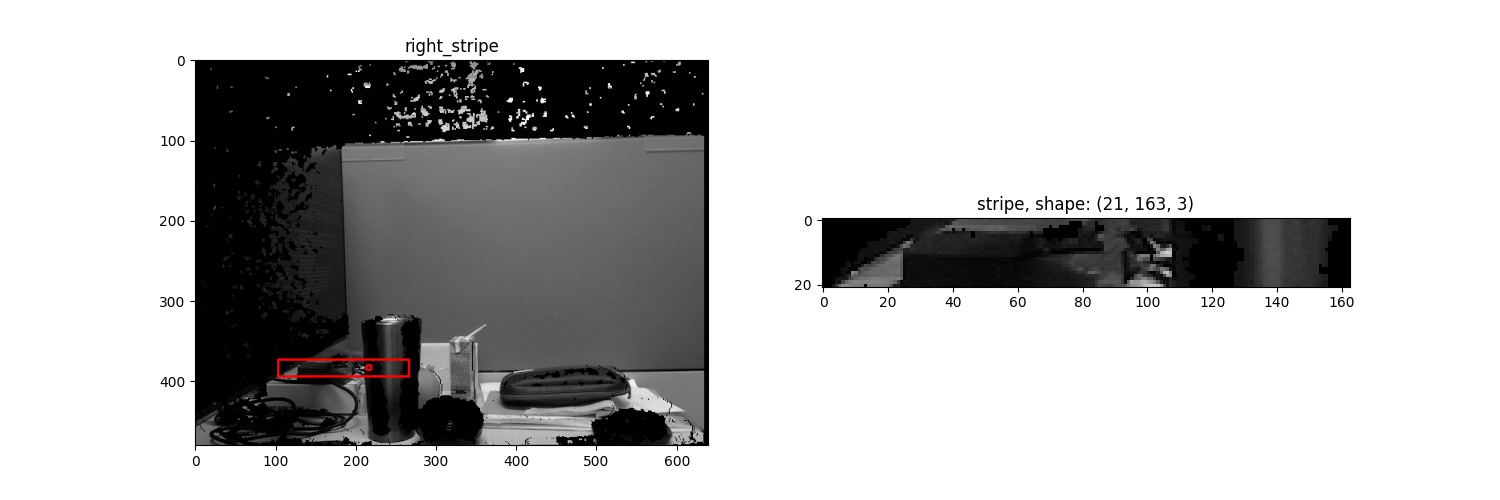

In [57]:
# Make a stripe
right_stripe, stripe, _, stripe_status = getStripe(right_image=right_image,
                                                   left_kp=left_kp,
                                                   templ_rows=templ_rows,
                                                   templ_cols=templ_cols,
                                                   stripe_extra_rows=yaml_data["stripe_extra_rows"])

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(right_stripe)
axs[0].set_title("right_stripe")
axs[1].imshow(stripe)
axs[1].set_title(f"stripe, shape: {stripe.shape}")
plt.show()

In [58]:
def getRightFrameKeypoint(kp_idx, visualize=False):
    print(f"keypoint index: {kp_idx}")
    
    # Match Template
    templ_rows = yaml_data["templ_rows"]
    # templ_cols = 101
    templ_cols = yaml_data["templ_cols"]
    # stripe_extra_rows = 10
    stripe_extra_rows = yaml_data["stripe_extra_rows"]
    tolerance = yaml_data["toleranceTemplateMatching"]

    left_templ, templ, offset_temp, temp_status = getTemplate(left_image=left_image,
                                                              left_kp=lkf_kps[kp_idx],
                                                              templ_rows=templ_rows,
                                                              templ_cols=templ_cols)
    right_stripe, stripe, stripe_corner, stripe_status = getStripe(right_image=right_image,
                                                                   left_kp=lkf_kps[kp_idx],
                                                                   templ_rows=templ_rows,
                                                                   templ_cols=templ_cols,
                                                                   stripe_extra_rows=stripe_extra_rows)

    if temp_status != "KeypointStatus::VALID" or stripe_status != "KeypointStatus::VALID":
        print("---")
        print("Something got wrong. Ending function...")
        print("")
        return False, tuple()

    # right keypoint
    matching_result = cv2.matchTemplate(stripe, templ, cv2.TM_SQDIFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(matching_result)

    matchLoc = list(min_loc)
    matchLoc[0] += stripe_corner[0] + (templ_cols - 1) / 2 + offset_temp
    matchLoc[1] += stripe_corner[1] + (templ_rows - 1) / 2

    right_kp_valid = min_val < tolerance
    
    # Print result
    print(f"tolerance: {tolerance}")
    print("min_value: {:.15f}".format(min_val))
    print("is right keypoint valid?: {}".format("Yes" if right_kp_valid else "No!!!"))
    print(f"---")
    print(f"left frame keypoint{lkf_kps[kp_idx].pt}, right frame keypoint{matchLoc}")

    if visualize:
        # Plot template & stripe & matching result
        fig = plt.figure(layout="constrained", figsize=(15, 5))
        ax_dict = fig.subplot_mosaic(
            [
                ["left_templ", "templ", "matching_result"],
                ["right_stripe", "stripe", "matching_result"],
            ],
        )
        fig.suptitle(f"keypoint No.{kp_idx}")
        ax_dict["left_templ"].imshow(left_templ)
        ax_dict["left_templ"].set_title("left_templ")
        ax_dict["templ"].imshow(templ)
        ax_dict["templ"].set_title(f"template: {templ.shape[:-1]}")
        ax_dict["right_stripe"].imshow(right_stripe)
        ax_dict["right_stripe"].set_title("right_stripe")
        ax_dict["stripe"].imshow(stripe)
        ax_dict["stripe"].set_title(f"stripe: {stripe.shape[:-1]}")
        mr = ax_dict["matching_result"].imshow(matching_result)
        ax_dict["matching_result"].set_title(f"matching_result: {min_loc}, {right_kp_valid}")
        fig.colorbar(mr, ax=ax_dict["matching_result"])

        # plot keypoint area patch
        half_width = 30
        int_lkf_kp_pt = tuple(map(int, lkf_kps[kp_idx].pt))
        int_matchLoc = tuple(map(int, matchLoc))

        left_patch = deepcopy(left_image)[int_lkf_kp_pt[1] - half_width : int_lkf_kp_pt[1] + half_width,
                                        int_lkf_kp_pt[0] - half_width : int_lkf_kp_pt[0] + half_width]
        right_image_post = deepcopy(right_image)
        right_image_post[int_lkf_kp_pt[1], int_lkf_kp_pt[0]] = (255, 0, 0)  # left frame keypoint coordinate
        right_patch = right_image_post[int_matchLoc[1] - half_width : int_matchLoc[1] + half_width,
                                    int_matchLoc[0] - half_width : int_matchLoc[0] + half_width]

        left_patch[half_width, half_width] = (255, 0, 0)  # center dot
        cv2.circle(left_patch, (half_width, half_width), 3, (255, 0, 0), 1)  # circle
        right_patch[half_width, half_width] = (0, 255, 0)  # center dot
        cv2.circle(right_patch, (half_width, half_width), 3, (0, 255, 0), 1)  # circle

        fig2, axs = plt.subplots(1, 2, figsize=(15, 5))
        axs[0].imshow(left_patch)
        axs[1].imshow(right_patch)

        plt.show()
    else:
        print(f"(visualize set to {visualize})")
        print(f"=============================")
        print("")
    
    return right_kp_valid, matchLoc

In [59]:
def getDepth(kp_idx, right_kp):
    # fx = 648.62802467
    # baseline = 0.008889568098128261

    # depth
    disparity = lkf_kps[kp_idx].pt[0] - right_kp[0]
    if disparity > 0:
        depth = FX * BASELINE / disparity
    else:
        depth = np.inf
    min_point_dist = yaml_data["minPointDist"]
    max_point_dist = yaml_data["maxPointDist"]
    depth_valid = min_point_dist < depth < max_point_dist

    # print Result
    print(f"disparity: {disparity}")
    print(f"depth: {depth}, valid range: [{min_point_dist}, {max_point_dist}]")
    print("is depth valid?: {}".format("Yes" if depth_valid else "No!!!" ))

    return depth_valid, depth

keypoint index: 670
tolerance: 0.15
min_value: 0.011442041955888
is right keypoint valid?: Yes
---
left frame keypoint(431.0, 410.0), right frame keypoint[425.0, 410.0]


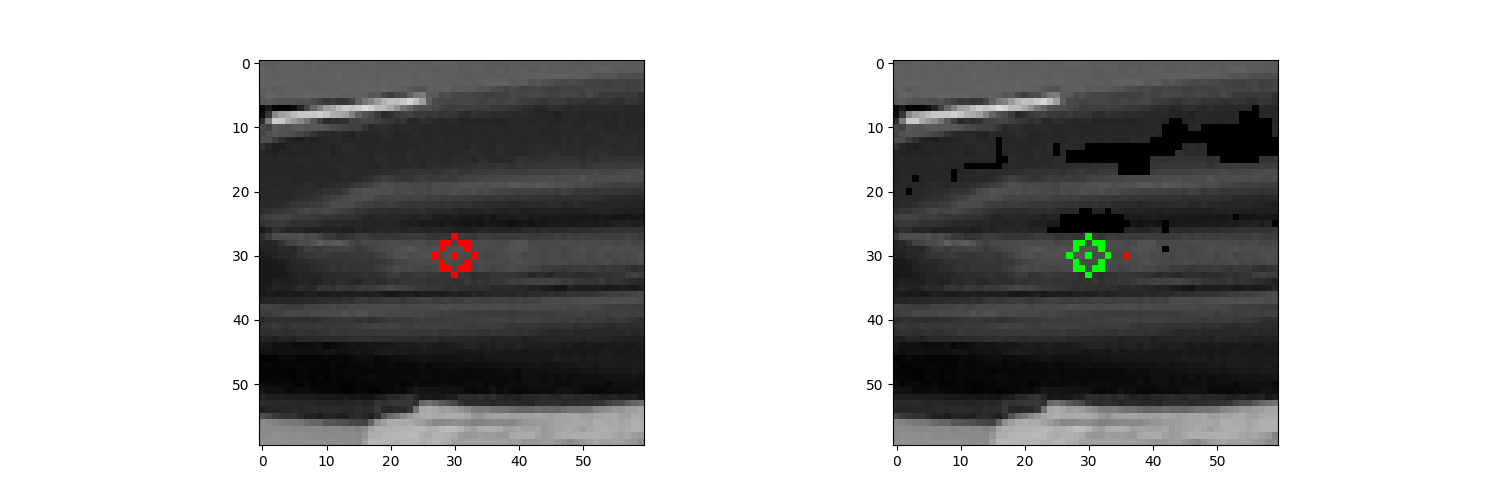

disparity: 6.0
depth: 0.9610038326097303, valid range: [0.1, 10]
is depth valid?: Yes


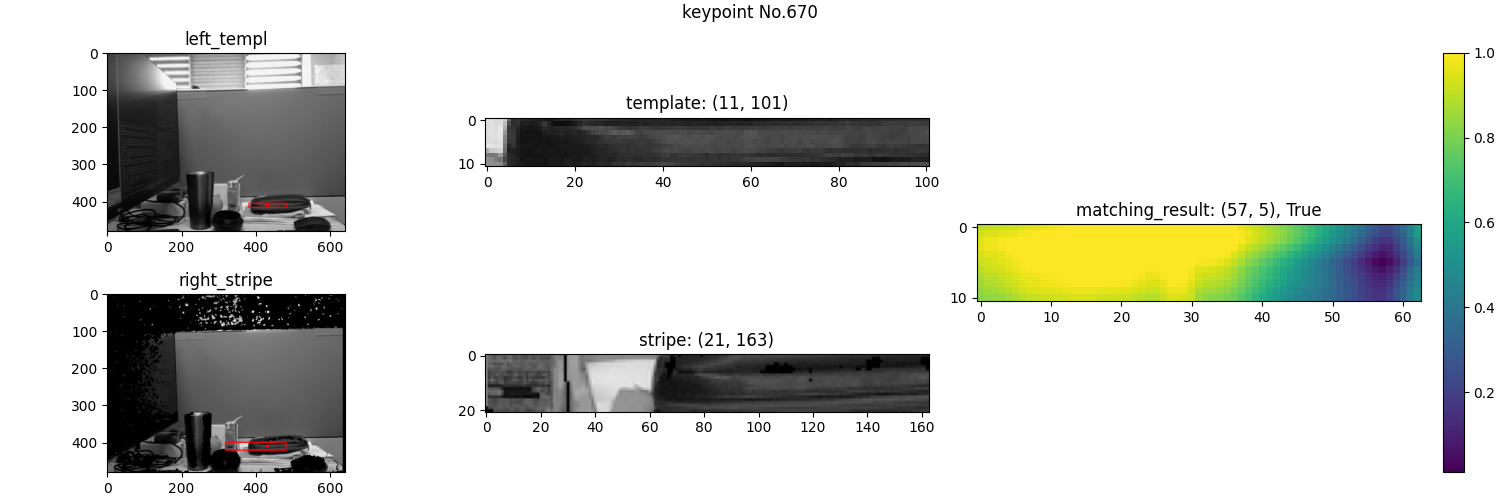

In [60]:
# Execute result
kp_idx = 670

right_kp_valid, right_kp = getRightFrameKeypoint(kp_idx=kp_idx, visualize=True)
depth_valid, depth = getDepth(kp_idx=kp_idx, right_kp=right_kp)

In [61]:
# Iterate with all keypoints
right_kp_valid_list = []
depth_valid_list = []
right_kps = []
depths = []

for i in range(len(lkf_kps)):
    # right keypoint
    right_kp_valid, right_kp = getRightFrameKeypoint(kp_idx=i)
    right_kp_valid_list.append(right_kp_valid)
    right_kps.append(right_kp)

    # depth
    if right_kp_valid:
        depth_valid, depth = getDepth(kp_idx=i, right_kp=right_kp)
        depth_valid_list.append(depth_valid)
        depths.append(depth)
    else:
        depth_valid_list.append(False)
        depths.append(0)

keypoint index: 0
tolerance: 0.15
min_value: 0.093429826200008
is right keypoint valid?: Yes
---
left frame keypoint(216.0, 383.0), right frame keypoint[210.0, 383.0]
(visualize set to False)

disparity: 6.0
depth: 0.9610038326097303, valid range: [0.1, 10]
is depth valid?: Yes
keypoint index: 1
tolerance: 0.15
min_value: 0.008546861819923
is right keypoint valid?: Yes
---
left frame keypoint(544.0, 416.0), right frame keypoint[538.0, 416.0]
(visualize set to False)

disparity: 6.0
depth: 0.9610038326097303, valid range: [0.1, 10]
is depth valid?: Yes
keypoint index: 2
tolerance: 0.15
min_value: 0.014231186360121
is right keypoint valid?: Yes
---
left frame keypoint(545.0, 399.0), right frame keypoint[539.0, 399.0]
(visualize set to False)

disparity: 6.0
depth: 0.9610038326097303, valid range: [0.1, 10]
is depth valid?: Yes
keypoint index: 3
tolerance: 0.15
min_value: 0.018707357347012
is right keypoint valid?: Yes
---
left frame keypoint(356.0, 353.0), right frame keypoint[349.0, 353

In [62]:
# Individual result
right_kp_valid_array = np.array(right_kp_valid_list).astype('int')
depth_valid_array = np.array(depth_valid_list).astype('int')
finally_valid_array = right_kp_valid_array * depth_valid_array

print(f"success {finally_valid_array.sum()} out of {len(lkf_kps)}")

invalid_kp_indices = []
valid_kp_indices = []
for i, valid in enumerate(finally_valid_array):
    if valid == True:
        valid_kp_indices.append(i)
    else:
        invalid_kp_indices.append(i)

# print("valid indices:")
# print(valid_kp_indices)

success 218 out of 694


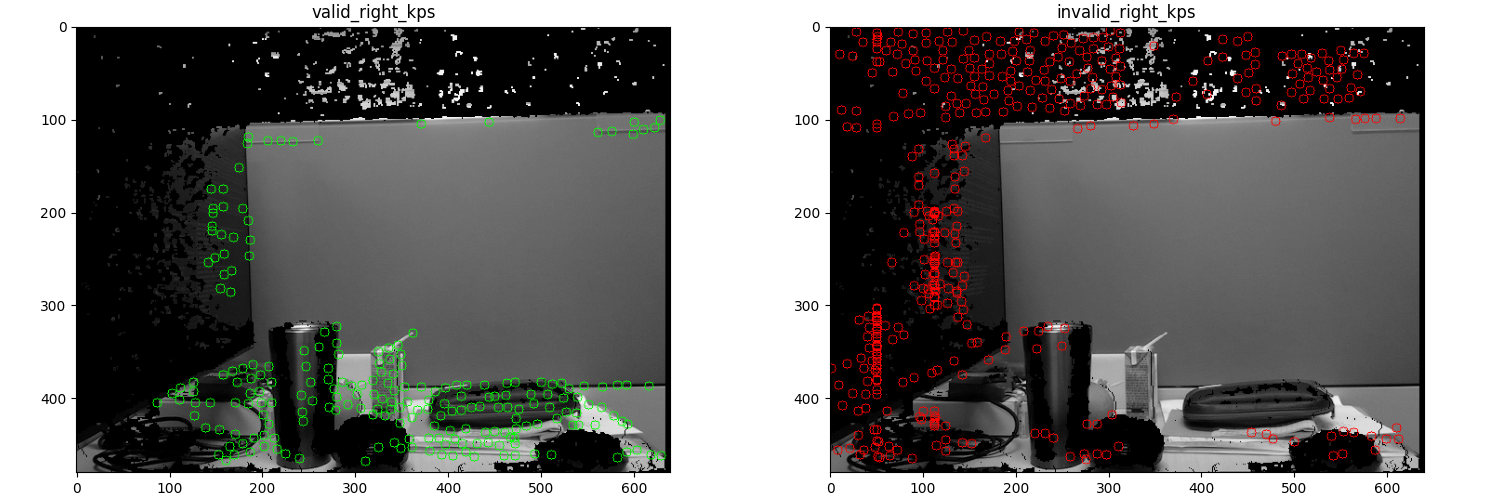

In [63]:
# Valid keypoints
valid_right_kps = deepcopy(right_image)

for valid_i in valid_kp_indices:
    cv2.circle(valid_right_kps, tuple(map(int, right_kps[valid_i])), 5, (0, 255, 0), 1)

# Invalid keypoints
invalid_right_kps = deepcopy(right_image)

for invalid_i in invalid_kp_indices:
    if len(right_kps[invalid_i]) > 0:
        cv2.circle(invalid_right_kps, tuple(map(int, right_kps[invalid_i])), 5, (255, 0, 0), 1)

fig, axs = plt.subplots(1, 2, figsize=(15, 5), layout="constrained")
axs[0].imshow(valid_right_kps)
axs[0].set_title("valid_right_kps")
axs[1].imshow(invalid_right_kps)
axs[1].set_title("invalid_right_kps")
plt.show()

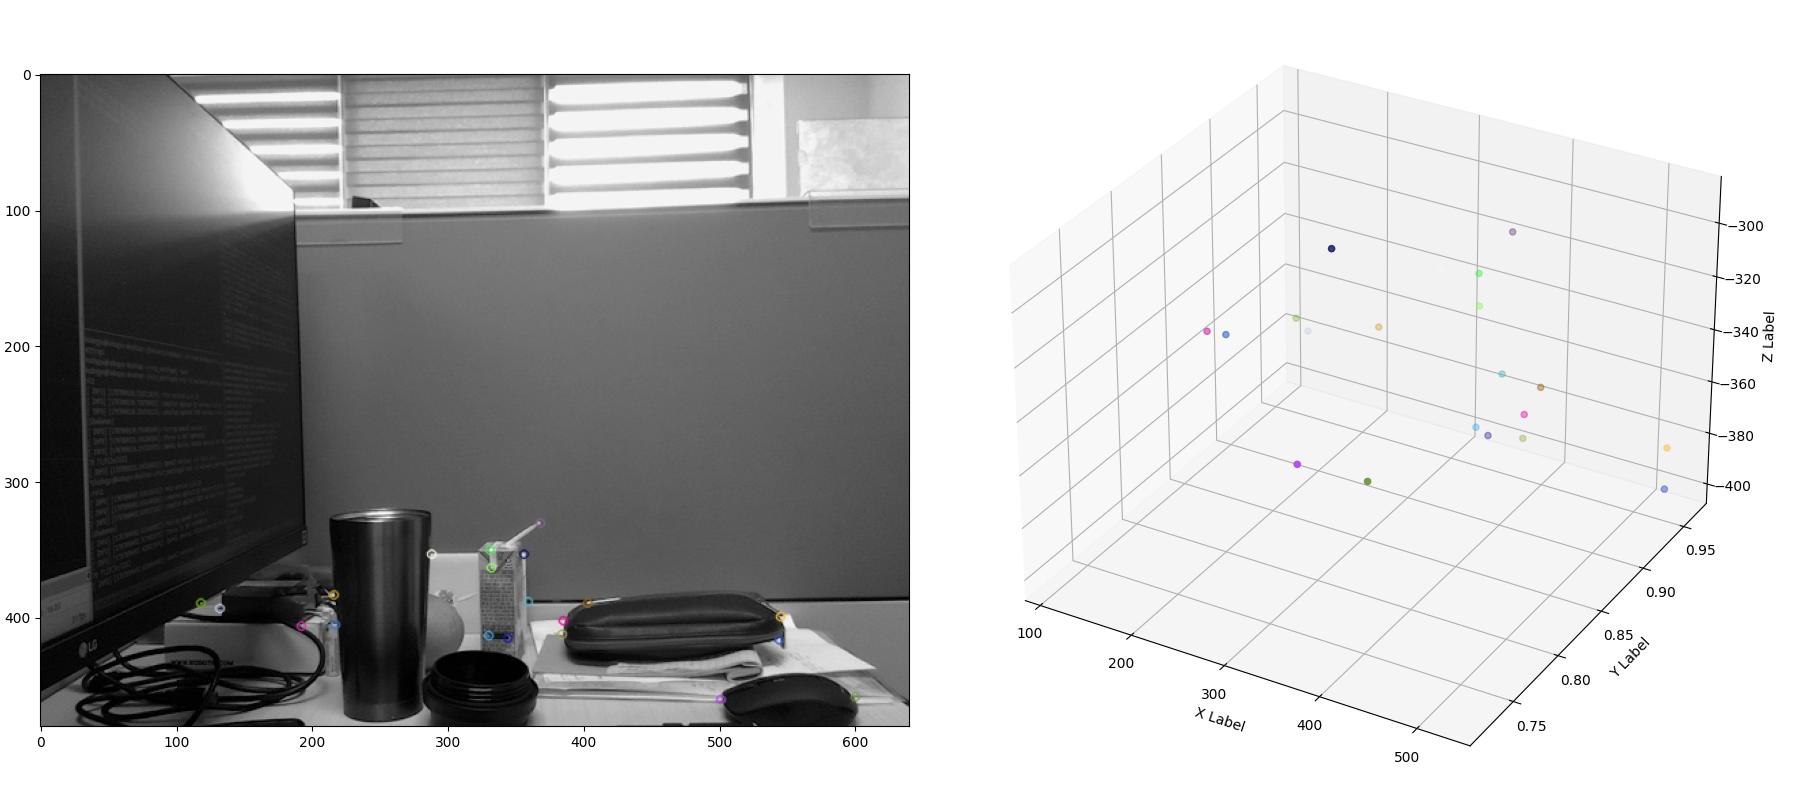

/home/kodogyu/.local/lib/python3.8/site-packages/ipympl/backend_nbagg.py:279: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  self.manager.handle_json(content)


In [70]:
# left keypoints
valid_left_kps = []
for i, valid_kp in enumerate(finally_valid_array):
    if valid_kp:
        valid_left_kps.append(lkf_kps[i])

colors = []
for valid_kp in valid_left_kps:
    if valid_kp:
        red = np.random.randint(0, 256)
        green = np.random.randint(0, 256)
        blue = np.random.randint(0, 256)
    else:
        red = green = blue = 0
    colors.append((red, green, blue))

# 3D keypoints
keypoints_3d = []
kp_idx = 0

for kp_idx, valid_kp in enumerate(finally_valid_array):
    if valid_kp:
        versor = list(lkf_kps[kp_idx].pt)
        versor.append(1.0)
        versor = versor / np.linalg.norm(versor)
        # print(f"versor: {versor}")

        keypoint_3d = versor * (depths[kp_idx] / versor[2])
        # print(f"depth: {depths[kp_idx]}")
        # print(f"3d keypoint: {keypoint_3d}")
        keypoints_3d.append(keypoint_3d)

keypoints_3d = np.array(keypoints_3d)

# Only few points
quantity = 20
valid_left_kps = valid_left_kps[:quantity]
keypoints_3d = keypoints_3d[:quantity]
colors = colors[:quantity]

# Plot 
left_key_frame_valid_kp = deepcopy(left_image)
for i, keypoint in enumerate(valid_left_kps):
    left_key_frame_valid_kp = cv2.drawKeypoints(left_key_frame_valid_kp, [keypoint], None, colors[i])

fig = plt.figure(figsize=(18, 8), layout="constrained")
# left frame
ax0 = fig.add_subplot(121)
ax0.imshow(left_key_frame_valid_kp)

# 3D keypoints
ax1 = fig.add_subplot(122, projection='3d')
ax1.scatter(keypoints_3d[:, 0], keypoints_3d[:, 2], -keypoints_3d[:, 1], c=np.array(colors)/255)
ax1.set_xlabel('X Label')
ax1.set_ylabel('Y Label')
ax1.set_zlabel('Z Label')

plt.show()